# Home Credit Default Risk
Predict how capable each applicant is of repaying a loan.

<img src="../input/breno-assis-517356-unsplash.jpg" style="height:500px">

Photo [Breno Assis](https://unsplash.com/@brenoassis)

## Context

This [challenge](https://www.kaggle.com/c/home-credit-default-risk) was proposed by __Home Credit Group__.

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

## Goal

Use historical loan application data to **predict whether or not an applicant will be able to repay a loan**. This is a standard **supervised classification task**.

Submissions are evaluated on **area under the ROC curve** between the predicted probability and the observed target.

## Type of ML
* Supervised: Labels are included in the training data
* Binary classification: target has only two values 0 (will repay loan on time), 1 (will have difficulty repaying loan)

## Guidelines 

* Download and load the data
* Sample the data in order to work on a smaller subset at first
* Explore the data, creating functions for cleaning it
* Split your data into features & labels ; training & testing
* Train different models and compare performance
* Train on your entire dataset, run predictions on your entire dataset and submit your results!
* Iterate

---

# Data

## First insight

In [1]:
# usual data science stack in python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("../input/"))

# Any results you write to the current directory are saved as output.

['application_train.csv', 'home_credit.png', 'ROC-curve.png', 'HomeCredit_columns_description_perso.csv', 'breno-assis-517356-unsplash.jpg', 'application_test.csv', 'home-credit-default-risk.zip']


In [2]:
# imports of need modules in sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier

In [3]:
import lightgbm as lgb
import xgboost as xgb

In [4]:
# set options in this notebook
pd.set_option('display.max_columns', 300)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
path_train = os.path.join('..', 'input', 'application_train.csv')
path_test = os.path.join('..', 'input', 'application_test.csv')

In [6]:
# load main datasets
app_train, app_test = pd.read_csv(path_train), pd.read_csv(path_test)

In [7]:
# 1st insight
app_train.tail()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032561,-9327,-236,-8456.0,-1982,NaN,1,1,0,1,0,0,Sales staff,1.0,1,1,THURSDAY,15,0,0,0,0,0,0,Services,0.145570,0.681632,NaN,0.2021,0.0887,0.9876,0.8300,0.0202,0.22,0.1034,0.6042,0.2708,0.0594,0.1484,0.1965,0.0753,0.1095,0.1008,0.0172,0.9782,0.7125,0.0172,0.0806,0.0345,0.4583,0.0417,0.0094,0.0882,0.0853,0.0,0.0125,0.2040,0.0887,0.9876,0.8323,0.0203,0.22,0.1034,0.6042,0.2708,0.0605,0.1509,0.2001,0.0757,0.1118,reg oper account,block of flats,0.2898,"Stone, brick",No,0.0,0.0,0.0,0.0,-273.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.025164,-20775,365243,-4388.0,-4090,NaN,1,0,0,1,1,0,NaN,1.0,2,2,MONDAY,8,0,0,0,0,0,0,XNA,NaN,0.115992,NaN,0.0247,0.0435,0.9727,0.6260,0.0022,0.00,0.1034,0.0833,0.1250,0.0579,0.0202,0.0257,0.0000,0.0000,0.0252,0.0451,0.9727,0.6406,0.0022,0.0000,0.1034,0.0833,0.1250,0.0592,0.0220,0.0267,0.0,0.0000,0.0250,0.0435,0.9727,0.6310,0.0022,0.00,0.1034,0.0833,0.1250,0.0589,0.0205,0.0261,0.0000,0.0000,reg oper account,block of flats,0.0214,"Stone, brick",No,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,Unaccompanied,Working,Higher education,Separated,House / apartment,0.005002,-14966,-7921,-6737.0,-5150,NaN,1,1,0,1,0,1,Managers,1.0,3,3,THURSDAY,9,0,0,0,0,1,1,School,0.744026,0.535722,0.218859,0.1031,0.0862,0.9816,0.7484,0.0123,0.00,0.2069,0.1667,0.2083,NaN,0.0841,0.9279,0.0000,0.0000,0.1050,0.0894,0.9816,0.7583,0.0124,0.0000,0.2069,0.1667,0.2

In [8]:
app_train.shape, app_test.shape

((307511, 122), (48744, 121))

Of course, the column named 'TARGET' is not in the test dataset.

## Content of each table and links between tables

* __application_{train|test}.csv__
    * This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
    * Static data for all applications. One row represents one loan in our data sample.
* __bureau.csv__
    * All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
    * For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.
* __bureau_balance.csv__
    * Monthly balances of previous credits in Credit Bureau.
    * This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.
* __POS_CASH_balance.csv__
    * Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
    * This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.
* __credit_card_balance.csv__
    * Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
    * This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.
* __previous_application.csv__
    * All previous applications for Home Credit loans of clients who have loans in our sample.
    * There is one row for each previous application related to loans in our data sample.
* __installments_payments.csv__
    * Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
    * There is a) one row for every payment that was made plus b) one row each for missed payment.
    * One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.
* __HomeCredit_columns_description.csv__
    * This file contains descriptions for the columns in the various data files.


<img src="../input/home_credit.png" style="height:500px">

---

# Exploratory Data Analysis¶

## Distribution of the Target Column

In [9]:
app_train.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [10]:
print(f'percentage of clients with payment difficulties: {app_train.TARGET.sum() / app_train.shape[0] * 100 :.2f}%')

percentage of clients with payment difficulties: 8.07%


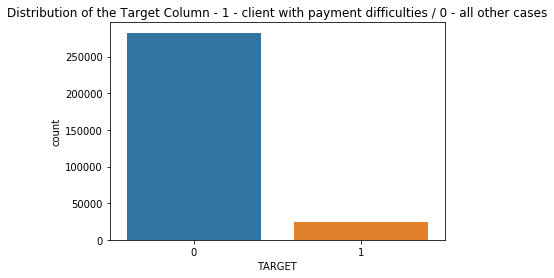

In [11]:
plt.title('Distribution of the Target Column - 1 - client with payment difficulties / 0 - all other cases')
sns.countplot(x=app_train.TARGET, data=app_train)
plt.show()

This is an [imbalanced class problem](http://www.chioka.in/class-imbalance-problem/). There are far more repaid loans than loans that were not repaid. It is important to weight the classes by their representation in the data to reflect this imbalance.

## Column Types

In [12]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

int64 and float64 are numeric variables which can correspond to discrete or continuous features. 
Whereas object columns contain strings and are categorical features.

In [13]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

## Missing Values

In [14]:
# Function to calculate missing values by column# Funct // credits Will Koehrsen
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [15]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(10)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


From here we have 2 options :
    * Use models such as XGBoost that can handle missing values
    * Or drop columns with a high percentage of missing values, and fill in other columns with a low percentage
It is not possible to know ahead of time if these columns will be helpful or not. My choice here is to drop them. Later if we need a more accurate score, we'll change the way to proceed.

### Dropping columns with a high ratio of missing values

In [16]:
# cols_to_drop = list((app_train.isnull().sum() > 75000).index)
cols_to_drop = [c for c in app_train.columns if app_train[c].isnull().sum() > 75000]

In [17]:
app_train, app_test = app_train.drop(cols_to_drop, axis=1), app_test.drop(cols_to_drop, axis=1)
app_test.isnull().sum().sort_values(ascending=False).head(10)

EXT_SOURCE_3                  8668
AMT_REQ_CREDIT_BUREAU_YEAR    6049
AMT_REQ_CREDIT_BUREAU_MON     6049
AMT_REQ_CREDIT_BUREAU_WEEK    6049
AMT_REQ_CREDIT_BUREAU_DAY     6049
AMT_REQ_CREDIT_BUREAU_HOUR    6049
AMT_REQ_CREDIT_BUREAU_QRT     6049
NAME_TYPE_SUITE                911
DEF_60_CNT_SOCIAL_CIRCLE        29
OBS_60_CNT_SOCIAL_CIRCLE        29
dtype: int64

### Filling other missing values

In [18]:
obj_cols = app_train.select_dtypes('object').columns
obj_cols

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE'],
      dtype='object')

In [19]:
# filling string cols with 'Not specified' 
app_train[obj_cols] = app_train[obj_cols].fillna('Not specified')
app_test[obj_cols] = app_test[obj_cols].fillna('Not specified')

In [20]:
float_cols = app_train.select_dtypes('float').columns
float_cols

Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'CNT_FAM_MEMBERS',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [21]:
# filling float values with median of train (not test)
app_train[float_cols] = app_train[float_cols].fillna(app_train[float_cols].median())
app_test[float_cols] = app_test[float_cols].fillna(app_test[float_cols].median())

In [22]:
app_train.shape, app_test.shape

((307511, 72), (48744, 71))

Let's check if there is still NaNs

In [23]:
app_train.isnull().sum().sort_values(ascending=False).head()

AMT_REQ_CREDIT_BUREAU_YEAR    0
AMT_REQ_CREDIT_BUREAU_QRT     0
DAYS_REGISTRATION             0
DAYS_ID_PUBLISH               0
FLAG_MOBIL                    0
dtype: int64

In [24]:
app_test.isnull().sum().sort_values(ascending=False).head()

AMT_REQ_CREDIT_BUREAU_YEAR    0
FLAG_EMAIL                    0
DAYS_ID_PUBLISH               0
FLAG_MOBIL                    0
FLAG_EMP_PHONE                0
dtype: int64

In [25]:
# Is there any duplicated rows ?

In [26]:
app_train.duplicated().sum()

0

In [27]:
app_test.duplicated().sum()

0

## Categorical columns (type object)

In [28]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                8
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
dtype: int64

## Dealing with anomalies

In [29]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

The maximum value is abnormal (besides being positive). It corresponds to 1000 years...

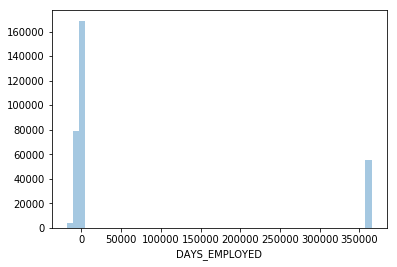

In [30]:
sns.distplot(app_train['DAYS_EMPLOYED'], kde=False);
plt.show()

In [31]:
print('The non-anomalies default on %0.2f%% of loans' % (100 * app_train[app_train['DAYS_EMPLOYED'] != 365243]['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * app_train[app_train['DAYS_EMPLOYED'] == 365243]['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(app_train[app_train['DAYS_EMPLOYED'] == 365243]))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


It turns out that the anomalies have a lower rate of default.

The anomalous values seem to have some importance. Let's fill in the anomalous values with not a np.nan and then create a new boolean column indicating whether or not the value was anomalous.

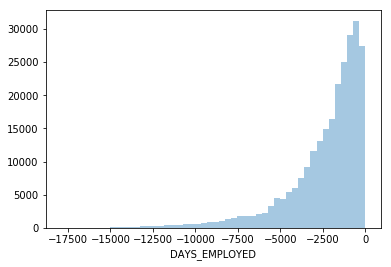

In [32]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

sns.distplot(app_train['DAYS_EMPLOYED'].dropna(), kde=False);

In [33]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


In [34]:
# refilling float values with median of train (not test)

app_train[float_cols] = app_train[float_cols].apply(pd.to_numeric, errors='coerce')
app_train = app_train.fillna(app_train.median())

app_test[float_cols] = app_test[float_cols].apply(pd.to_numeric, errors='coerce')
app_test = app_train.fillna(app_test.median())

## Correlations

The correlation coefficient is not the best method to represent "relevance" of a feature, but it gives us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

* 00-.19 “very weak”
* 20-.39 “weak”
* 40-.59 “moderate”
* 60-.79 “strong”
* 80-1.0 “very strong”

In [35]:
correlations = app_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(10))
print('\n\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.063368
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64


Most Negative Correlations:
 EXT_SOURCE_2                 -0.160295
EXT_SOURCE_3                 -0.155892
DAYS_EMPLOYED_ANOM           -0.045987
AMT_GOODS_PRICE              -0.039623
REGION_POPULATION_RELATIVE   -0.037227
AMT_CREDIT                   -0.030369
FLAG_DOCUMENT_6              -0.028602
HOUR_APPR_PROCESS_START      -0.024166
FLAG_PHONE                   -0.023806
AMT_REQ_CREDIT_BUREAU_MON    -0.014794
Name: TARGET, dtype: float64


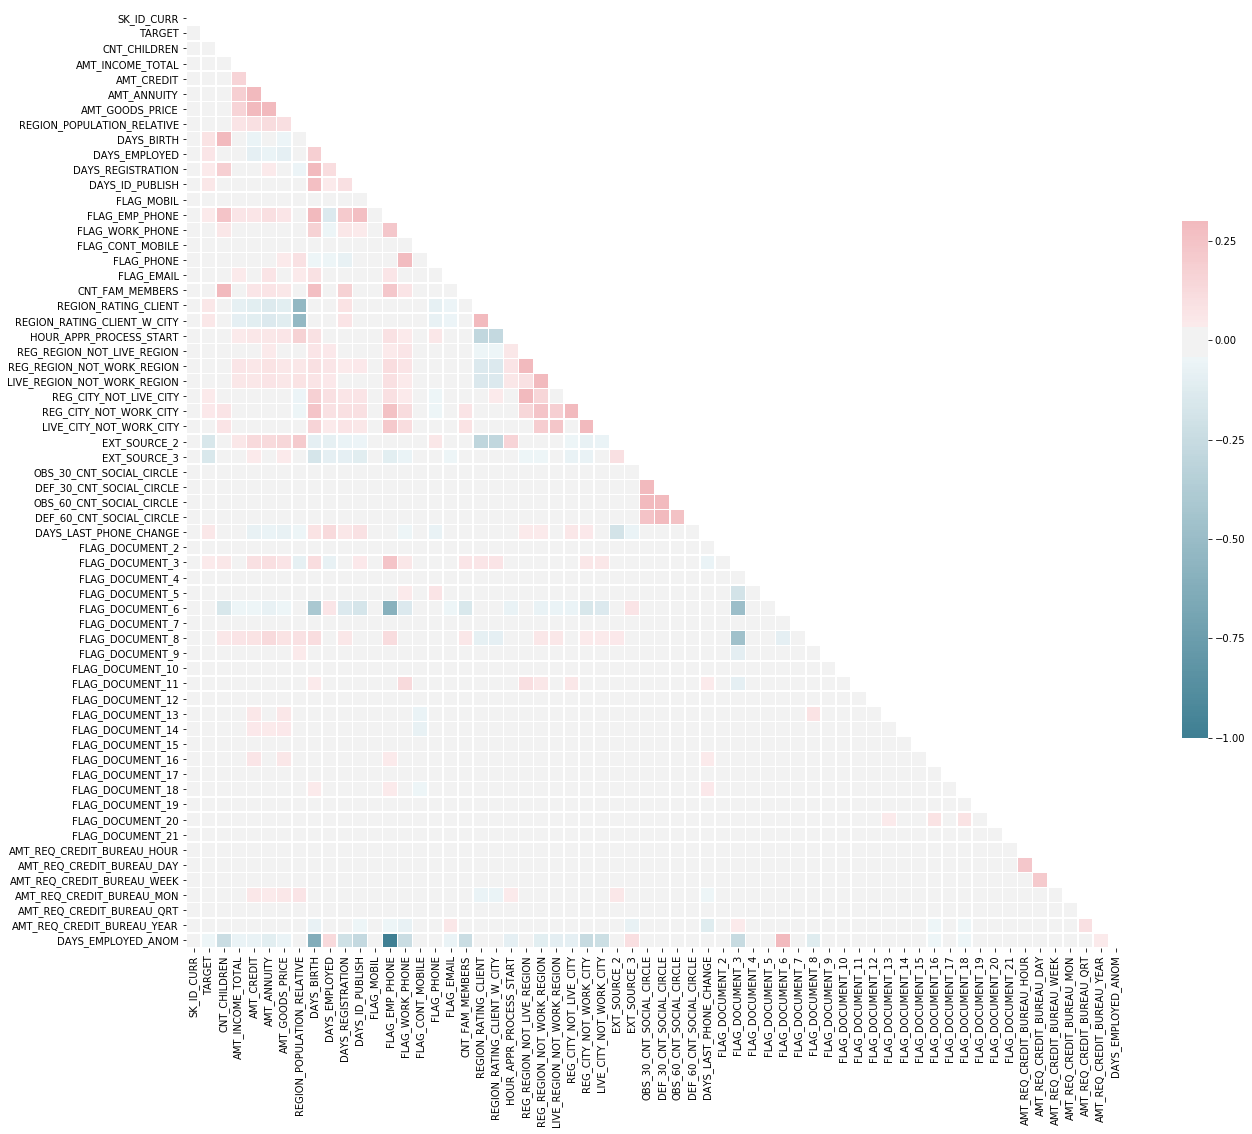

In [36]:
# Compute the correlation matrix
corr = app_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(21, 19))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Effect of Age on Repayment

In [37]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982712

There isn't any correlation between age and repayment

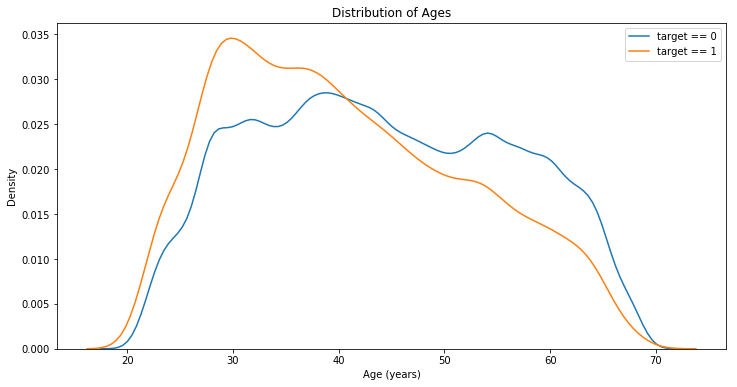

In [38]:
plt.figure(figsize = (12, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [39]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

/home/sunflowa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sunflowa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [40]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


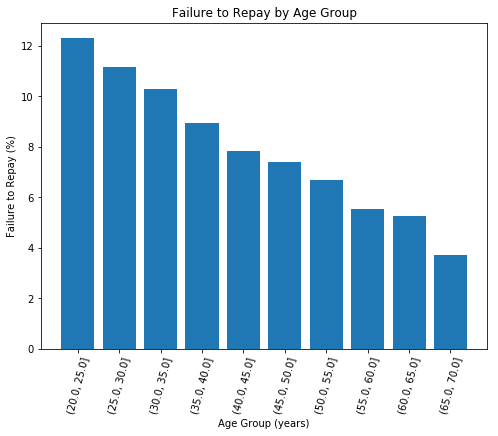

In [41]:
plt.figure(figsize = (8, 6))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

Younger applicants are more likely to not repay the loan.

# Preparing data

## Encoding Categorical Variables

A ML model can't deal with categorical features (except for some models such as LightGBM). 
One have to find a way to encode (represent) these variables as numbers. There are two main ways :

* Label encoding: assign each unique category in a categorical variable with an integer. No new columns are created. The problem with label encoding is that it gives the categories an arbitrary ordering.
* One-hot encoding: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns.  

In [42]:
app_train = pd.get_dummies(data=app_train, columns=obj_cols)
app_test = pd.get_dummies(data=app_test, columns=obj_cols)

## Aligning Training and Testing Data

Both the training and testing data should have the same features (columns). One-hot encoding can more columns in the one dataset because there were some categorical variables with categories not represented in the other dataset. In order to remove the columns in the training data that are not in the testing data, one need to align the dataframes.

In [43]:
# back up of the target /  need to keep this information
y = app_train.TARGET
app_train = app_train.drop(columns=['TARGET'])

In [44]:
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

In [45]:
app_train.shape, app_test.shape

((307511, 168), (307511, 168))

## Scaling values

In [46]:
feat_to_scale = list(float_cols).copy()
feat_to_scale.extend(['CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'HOUR_APPR_PROCESS_START'])
feat_to_scale

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'CNT_CHILDREN',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'HOUR_APPR_PROCESS_START']

In [47]:
scaler = StandardScaler()
app_train[feat_to_scale] = scaler.fit_transform(app_train[feat_to_scale])
app_test[feat_to_scale] = scaler.fit_transform(app_test[feat_to_scale])
app_train.head()

/home/sunflowa/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/sunflowa/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/sunflowa/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/sunflowa/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Not specified,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telec

## Splitting training / test datasets 
from app_train in order to make few predictions before submission & select models

In [48]:
X_train, X_test, y_train, y_test = train_test_split(app_train, y, test_size=0.2)

---

# Base line

## Metric: ROC AUC

more infos on [the Receiver Operating Characteristic Area Under the Curve (ROC AUC, also sometimes called AUROC)](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it).

The [Reciever Operating Characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) graphs the true positive rate versus the false positive rate:

<img src="../input/ROC-curve.png" style="height:300px">

A single line on the graph indicates the curve for a single model, and movement along a line indicates changing the threshold used for classifying a positive instance. The threshold starts at 0 in the upper right to and goes to 1 in the lower left. A curve that is to the left and above another curve indicates a better model. For example, the blue model is better than the red one (which is better than the black diagonal line which indicates a naive random guessing model).

The Area Under the Curve (AUC) is the integral of the curve. This metric is between 0 and 1 with a better model scoring higher. A model that simply guesses at random will have an ROC AUC of 0.5.

When we measure a classifier according to the ROC AUC, we do not generate 0 or 1 predictions, but rather a probability between 0 and 1. 

When we get into problems with inbalanced classes, accuracy is not the best metric. A model with a high ROC AUC will also have a high accuracy, but the ROC AUC is a better representation of model performance.

## Random forrest

In [49]:
# a simple RandomForrest Classifier without CV
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
roc_auc_score(y_test, y_pred)

0.5011674887648608

The predictions must be in the format shown in the sample_submission.csv file, where there are only two columns: SK_ID_CURR and TARGET. Let's create a dataframe in this format from the test set and the predictions called submit.

In [50]:
def submit(model, csv_name):
    
    # fit on the whole dataset of train
    model.fit(app_train, y)
    
    # Make predictions & make sure to select the second column only
    result = model.predict_proba(app_test)[:, 1]

    submit = app_test[['SK_ID_CURR']]
    submit['TARGET'] = result

    # Save the submission to a csv file
    submit.to_csv(csv_name, index = False)

In [51]:
# submit(rf, 'random_forrest_clf.csv')

The random forrest model should score around 0.58329 when submitted which is not really good, because just above 0.5 i.e a random classifier...

## Feature Importances

In [52]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(app_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 27 (0.064841)
2. feature 28 (0.059712)
3. feature 7 (0.046094)
4. feature 10 (0.045429)
5. feature 9 (0.045176)
6. feature 0 (0.044173)
7. feature 4 (0.041803)
8. feature 8 (0.041481)
9. feature 33 (0.041030)
10. feature 3 (0.039948)
11. feature 2 (0.035454)
12. feature 6 (0.035247)
13. feature 5 (0.033751)
14. feature 20 (0.031268)
15. feature 59 (0.022036)
16. feature 31 (0.017715)
17. feature 29 (0.017527)
18. feature 17 (0.013756)
19. feature 1 (0.010035)
20. feature 58 (0.008328)
21. feature 57 (0.007471)
22. feature 18 (0.006926)
23. feature 69 (0.006884)
24. feature 19 (0.006881)
25. feature 15 (0.006740)
26. feature 92 (0.006712)
27. feature 68 (0.006608)
28. feature 30 (0.006549)
29. feature 115 (0.006527)
30. feature 108 (0.006369)
31. feature 13 (0.006358)
32. feature 103 (0.006115)
33. feature 107 (0.006110)
34. feature 109 (0.006067)
35. feature 104 (0.005811)
36. feature 152 (0.005601)
37. feature 77 (0.005453)
38. feature 25 (0.005225)
39. fea

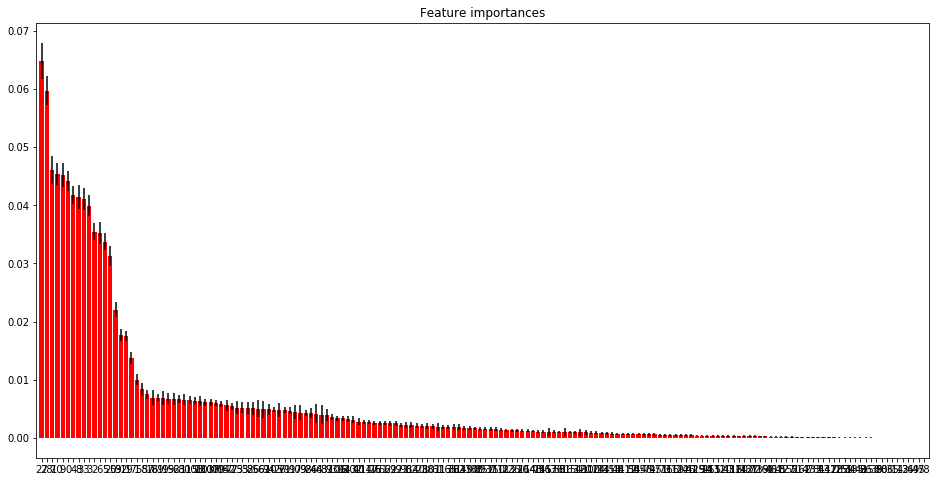

In [53]:
# Plot the feature importances of the rf
plt.figure(figsize=(16, 8))
plt.title("Feature importances")
plt.bar(range(app_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(app_train.shape[1]), indices)
plt.xlim([-1, app_train.shape[1]])
plt.show()

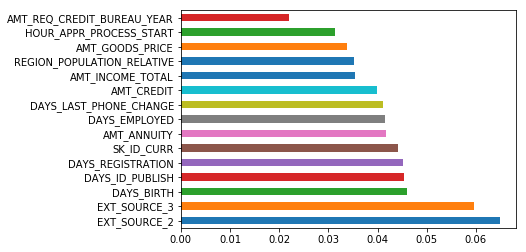

In [54]:
(pd.Series(rf.feature_importances_, index=app_train.columns)
   .nlargest(15)
   .plot(kind='barh'))

## Random forrest with a cross validation

In [55]:
rf_cv = RandomForestClassifier()
scores = cross_val_score(rf_cv, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
scores

array([0.63219173, 0.63231896, 0.62319801, 0.62533242, 0.62668538])

In [57]:
rf_cv.fit(X_train, y_train)
roc_auc_score(y_test, rf_cv.predict(X_test))

0.5036931060869384

In [58]:
#!pip install kaggle

In [59]:
#!kaggle competitions submit -c home-credit-default-risk -f randomforest_baseline.csv -m "My 1st submission - the baseline"

---

# More advanced models

## LightGBM 

In [62]:
lgbm = lgb.LGBMClassifier(random_state = 50)
lgbm.fit(X_train, y_train, eval_metric = 'auc')
roc_auc_score(y_train, lgbm.predict(X_train))

0.5108945200660795

In [63]:
roc_auc_score(y_test, lgbm.predict(X_test))

0.5069964776833696

Different tests on hyperparameters and results:

* underfitting / high biais -> let's try to complified the model
* max_depth = 7/11 or objective = 'binary' -> scores 0.508 / 0.508
* n_estimators=1000 -> scores 0.57 / 0.511
* class_weight = 'balanced' -> scores 0.71 / 0.68
* reg_alpha = 0.1, reg_lambda = 0.1 -> no influence

In [64]:
lgbm = lgb.LGBMClassifier(random_state = 50, n_jobs = -1, class_weight = 'balanced')
lgbm.fit(X_train, y_train, eval_metric = 'auc')
roc_auc_score(y_train, lgbm.predict(X_train))

0.7121220817520526

In [65]:
roc_auc_score(y_test, lgbm.predict(X_test))

0.6846561563080866

In [66]:
def submit_func(model, X_Test, file_name):
    model.fit(app_train, y)
    result = model.predict_proba(app_test)[:, 1]
    submit = app_test[['SK_ID_CURR']]
    submit['TARGET'] = result
    print(submit.head())
    print(submit.shape)
    submit.to_csv(file_name + '.csv', index=False)

In [67]:
submit_func(lgbm, app_test, 'lgbm_submission')

/home/sunflowa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


   SK_ID_CURR    TARGET
0      100002  0.876184
1      100003  0.237339
2      100004  0.293612
3      100006  0.427514
4      100007  0.634639
(307511, 2)


__submission -> 0.72057__

--- 

# Using XGBoost and weighted classes

As said earlier, there are far more 0 than 1 in the target column. This is an [imbalanced class problem].(http://www.chioka.in/class-imbalance-problem/).
    
It's a common problem affecting ML due to having disproportionate number of class instances in practice.
This is why the ROC AUC metric suits our needs here. There are 2 class of approaches out there to deal with this problem:

1) sampling based, that can be broken into three major categories: 

    a) over sampling 
    
    b) under sampling 
    
    c) hybrid of oversampling and undersampling.

2) cost function based. 

With default or few changes in hyperparameters

* base score : 0.50 / 0.709
* max_delta_step=2 -> unchanged
* with ratio : 0.68 / 0.71

In [68]:
y.shape[0], y.sum()

(307511, 24825)

In [69]:
ratio = (y.shape[0] - y.sum()) / y.sum()
ratio

11.387150050352467

In [70]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=50, eval_metric='auc', 
                              max_delta_step=2, scale_pos_weight=20)
xgb_model.fit(X_train, y_train)
roc_auc_score(y_train, xgb_model.predict(X_train))

0.656946528564419

In [71]:
roc_auc_score(y_test, xgb_model.predict(X_test))

0.6488130660302404

For common cases when the dataset is extremely imbalanced, this can affect the training of XGBoost model, and there are two ways to improve it.

If you care only about the overall performance metric (AUC) of your prediction
Balance the positive and negative weights via scale_pos_weight
Use AUC for evaluation

If you care about predicting the right probability
In such a case, you cannot re-balance the dataset
Set parameter max_delta_step to a finite number (say 1) to help convergence

In [72]:
submit_func(xgb_model, app_test, 'xgb_submission')

/home/sunflowa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


   SK_ID_CURR    TARGET
0      100002  0.908168
1      100003  0.408862
2      100004  0.452180
3      100006  0.607726
4      100007  0.763639
(307511, 2)


submission -> 0.72340

# Credits / side notes
[Will Koehrsen](https://www.kaggle.com/willkoehrsen/) for many interesting tips in his kernel !

This notebook is intended to be an introduction to machine learning. So many things are missing or can be done better, such as :

* Using function to clean / prepare the data
* Exploring the other tables and select other columns that can be relevant
* Doing more feature engineering, this will lead to a better score !